In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
import scipy
import warnings
warnings.filterwarnings("ignore")

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## RIFT-style Adaptive Sampling: A Minimal Example

This notebook demonstrates the principles behind RIFT, focusing on how we iteratively improve our estimate of a likelihood surface using adaptive sampling techniques.

At each iteration, we:
- Begin with an informed grid of points
- Calculate a marginalized likelihood for each point (intrinsic+extrinsic)
- Fit a Gaussian Process to the current log-likelihood samples.
- Use that GP to sample new points where the likelihood is high.
- "Puff" (perturb) the samples to explore the local region.
- Evaluate the likelihood at these new points.
- Repeat the process, refining our model each time.

See Section II of https://arxiv.org/pdf/1805.10457 for all details.

In [2]:
## First define our log-likelihood function
# This is a toy likelihood function: a Gaussian centered at the origin.
# The following few blocks are very general

def lnL_true(x, sigma=1.):
    """
    Compute a synthetic log-likelihood for testing.
    
    Parameters:
    - x : np.ndarray of shape (n_samples, n_dims)
        Input parameter values.
    - sigma : float
        Width of the Gaussian likelihood peak.
    
    Returns:
    - lnL : np.ndarray of shape (n_samples,)
        Log-likelihood evaluated at each input point.
    """
    squared_norms = np.sum(x**2, axis=1)
    lnL_vals = 45 - squared_norms / 2 * sigma**2
    #return 45-np.diagonal(np.dot(x,x.T))/2*sigma**2 #avoid building gigantic matrices
    return lnL_vals

Remember that the Gaussian likelihood is defined as

$ f(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} e^{-\frac{1}{2}\big(\frac{x-\mu}{\sigma}\big)^2} $

The data point $x$ is fixed and think of $f(x)$ is essentially a function of the parameters $\mu, \sigma$ - so $f(x)$ is the likelihood function which tells you how likely those parameters are given the observed data $x$.

More generally, the multidimensional Gaussian likelihood for a vector $ \mathbf{x} \in \mathbb{R}^d $, centered at $\mu = 0$ with , is given by:

$
\mathcal{L}(\mathbf{x}) = \frac{1}{(2\pi)^{d/2} |\Sigma|^{1/2}} \exp\bigg({-\frac{1}{2}(\mathbf{x}-\mu)^\top \Sigma^{-1}(\mathbf{x}-\mu)}\bigg)
$

and if we assume the Gaussian is centered at $\mu = 0$ and the covariance matrix is $ \Sigma = \sigma^2 \mathbf{I} 
$:

$
\mathcal{L}(\mathbf{x}) = \frac{1}{(2\pi\sigma^2)^{1/2}} e^{\left(-\frac{1}{2\sigma^2} \mathbf{x}^\top \mathbf{x}\right)}
$

Taking the natural logarithm to get the log-likelihood (good practice problem), the log-likelihood can be written as:

$ \ln \mathcal{L}(\mathbf{x}) = C - \frac{\mathbf{x}^\top \mathbf{x}}{2\sigma^2} $

So the log-likelihood is a quadratic function in $ \mathbf{x} $ with a constant offset $ C $. Here we choose an offset of 45 for ease of visuals and plotting


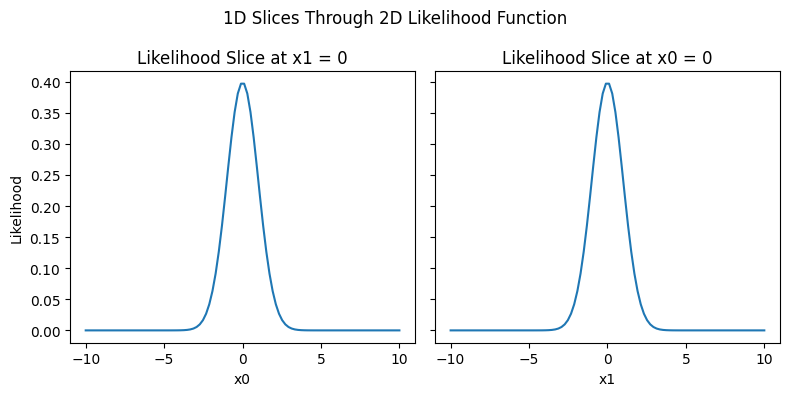

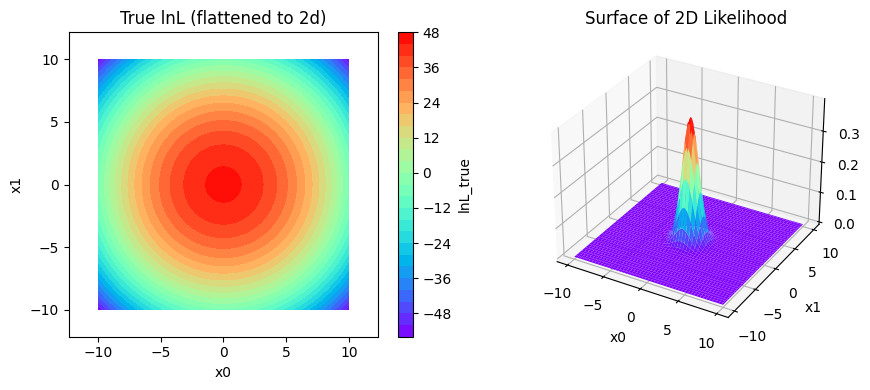

In [3]:
## We can visualize our 2D Gaussian as the following:
# mu = 0, sigma = 1
# This is the "true" log-likelihood surface we are trying 
# to learn through sampling. RIFT however never sees this surface 
# directly — it only sees the values of `lnL(x)` at selected sample points.

# Plot
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

# 1D slice: vary x0, fix x1 = 0
x0_vals = np.linspace(-10, 10, 100)
x0_points = np.stack([x0_vals, np.zeros_like(x0_vals)], axis=1)
lnL_x0 = lnL_true(x0_points)
L_x0 = (1/np.sqrt(2*np.pi)) * np.exp(lnL_x0 - 45)
axs[0].plot(x0_vals, L_x0)
axs[0].set_title("Likelihood Slice at x1 = 0")
axs[0].set_xlabel("x0")
axs[0].set_ylabel("Likelihood")

# 1D slice: vary x1, fix x0 = 0
x1_vals = np.linspace(-10, 10, 100)
x1_points = np.stack([np.zeros_like(x1_vals), x1_vals], axis=1)
lnL_x1 = lnL_true(x1_points)
L_x1 = (1/np.sqrt(2*np.pi)) * np.exp(lnL_x1 - 45)
axs[1].plot(x1_vals, L_x1)
axs[1].set_title("Likelihood Slice at x0 = 0")
axs[1].set_xlabel("x1")

fig.suptitle("1D Slices Through 2D Likelihood Function")
plt.tight_layout()
plt.show()

# Create figure with two subplots for colormaps
x_prior_max = 10
x_prior_min=-10
xv, yv = np.meshgrid(np.linspace(x_prior_min, x_prior_max, 100),
                     np.linspace(x_prior_min, x_prior_max, 100))
xgrid = np.vstack([xv.ravel(), yv.ravel()]).T
zgrid = lnL_true(xgrid).reshape(100, 100)


x0_grid, x1_grid = np.meshgrid(x0_vals, x1_vals)

# Stack into a grid of (N, 2) points
x_points = np.stack([x0_grid.ravel(), x1_grid.ravel()], axis=1)
lnL_vals = lnL_true(x_points)
L_vals = (1/np.sqrt(2*np.pi)) * np.exp(lnL_vals - 45)  # L not lnL

# Reshape for plotting
L_surface = L_vals.reshape(x0_grid.shape)

# Plot
fig = plt.figure(figsize=(9, 4))
# 2D contour plot
ax1 = fig.add_subplot(1, 2, 1)
contour = ax1.contourf(xv, yv, zgrid, levels=30, cmap='rainbow')
fig.colorbar(contour, ax=ax1, label="lnL_true")
ax1.set_title("True lnL (flattened to 2d)")
ax1.set_xlabel("x0")
ax1.set_ylabel("x1")
ax1.axis("equal")

# 3D surface plot
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
surf = ax2.plot_surface(x0_grid, x1_grid, L_surface, cmap='rainbow', edgecolor='none')
ax2.set_title("Surface of 2D Likelihood")
ax2.set_xlabel("x0")
ax2.set_ylabel("x1")
ax2.set_zlabel(r'$\mathcal{L}$')

plt.tight_layout()
plt.show()

### ILE: Integrate Likelihood Extrinsic

In practice, RIFT was first designed to be used for gravitational wave applications (though has now been extended to be able to take in any user-specified likelihood, which we call RIFT-hyperpipe). For GWs, the log-likelihood has the form:

$
\ln \mathcal{L}(\mathbf{\lambda};\theta) = -\frac{1}{2} \sum_k \langle h_k(\mathbf{\lambda},\theta)-d_k|h_k(\mathbf{\lambda},\theta)-d_k\rangle_k - \langle d_k|d_k\rangle_k
$

where $h_k$ are the predicted response of the kth detector due to a source with parameters $(\lambda, \theta)$ and $d_k$ are the detector data in each instrument $k$. $\lambda$ are the instrinsic parameters which uniquely
specify the binary’s dynamics, and $\theta$ represents the extrinsic parameters. This likelihood is n-dimensional and source dependent, it's shape related to the binary parameters, so it becomes very complicated (which is why we use a simple Gaussian likelihood for this demonstration).

RIFT is efficient in part because we calculate a marginalized likelihood over the extrinsic parameters - ie for each intrinsic point $\lambda$, we calculate the lieklihood for every corresponding $\theta$, which means we only calulcate the dynamics (expensive!) once and then examine every $(\lambda, \theta)$ for a temporarily fixed $\lambda$. Each $\lambda$ is independent, so these calculations can all be done in parallel.

For this tutorial, we continue with the simple Gaussian likelihood example defined above.

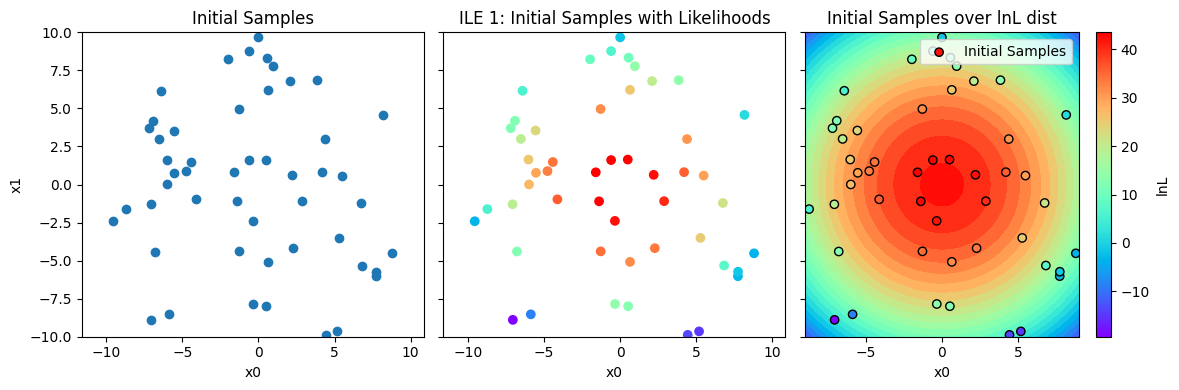

In [4]:
### Initial data ###
# Generate 50 example samples in our range
# Each sample has likelihood information (as if ILE already ran on these points)

x_in_init = np.random.uniform(x_prior_min, x_prior_max, size=(50, 2))
y_in_init = lnL_true(x_in_init) # "ILE"-like functionality: more complicated in practice!

fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
sc = axs[0].scatter(x_in_init[:, 0], x_in_init[:, 1])
axs[0].set_title("Initial Samples")
axs[0].set_xlabel("x0")
axs[0].set_ylabel("x1")
axs[0].axis("equal")

sc = axs[1].scatter(x_in_init[:, 0], x_in_init[:, 1], c=y_in_init, cmap='rainbow')
axs[1].set_title("ILE 1: Initial Samples with Likelihoods")
axs[1].set_xlabel("x0")
axs[1].axis("equal")

contour = axs[2].contourf(xv, yv, zgrid, levels=30, cmap='rainbow')
pts = axs[2].scatter(x_in_init[:, 0], x_in_init[:, 1], c=y_in_init, cmap='rainbow', edgecolor='black', label='Initial Samples')
axs[2].set_title("Initial Samples over lnL dist")
axs[2].set_xlabel("x0")
axs[2].legend(loc='upper right')
axs[2].axis("equal")
cbar1 = fig.colorbar(pts, ax=axs[2], location='right', label="lnL")

plt.tight_layout()
plt.show()

For this example, we start by drawing 50 uniform samples across the domain. These are evaluated using `lnL_true`, and used to fit the first model of the likelihood surface.

In practice, RIFT is initally given a Cartesian grid, where a user-specified number of points are evenly sampled for each parameter given a user-specified range and IS NOT informed by a likelihood function JUST the parameter ranges. 

Then, ILE runs on the initial grid to compute likelihoods for those parameter combinations. That is the likelihood information that then gets passed to CIP. Each instance of ILE first performs a "precomute" stage, where the dynamics and radiation are computed for a set of intrinsic parameters. Then, it iterates over *all* extrinsic parameter combinations for that intrinsic point and calculates a marginalized likelihood which is saved. Since these are independent calculations, and the precompute stage is the most computationally expensive part of the process, doing this dual stage computation for ILE is very efficient, and can be done in parallel (also efficient!).

### CIP: Construct Intrinsic Posterior

After ILE generates discrete marginalized likelihood information, the points are passed to the CIP stage. First, use Gaussian process (GP) interpolation to estimate the marginalized log-likelihood $\ln{\mathcal{L}_{\rm marg}}$ from a set of training data, incorporating uncertainties and using a flexible kernel. A GP basically says “let’s assume the function we’re trying to learn comes from a family of functions that are smooth and correlated in a certain way — and then use the data to update our beliefs.” To generate posterior samples, we theb apply adaptive Monte Carlo sampling in coordinates suited to both the likelihood shape and prior structure. The output is a set of weighted samples, which are resampled to produce an efficient, unweighted representation of the posterior, with reweighting used to adjust for different prior choices.

This example simplifies the process. First, we draw from a uniform prior, next evaluate the likelihood, and then resample points with probability proportional to their likelihood. This is essentially importance sampling: use uniform samples, weight them by the likelihood, and then resample according to those weights — just like they describe for their posterior construction. While RIFT uses more sophisticated coordinate systems and deals with prior reweighting and separability, this method still focuses on the core idea: fit a GP to the likelihood and sample from it.

Finally, we empoloy a puffball stage to jitter the CIP samples to ensure the space is well covered over the course of multiple iterations.

In [5]:
### Functions for GP, CIP, and PUFF ###
def fit_gp(x,y):
    """
    Fit a Gaussian Process (GP) regression model to input data with heuristically chosen kernel parameters.

    Parameters:
    ----------
    x : ndarray of shape (n_samples, n_coords)
        Input feature matrix (e.g., parameter coordinates).

    y : ndarray of shape (n_samples,)
        Target values (e.g., log-likelihoods or function evaluations).

    Returns:
    -------
    gp : GaussianProcessRegressor
        A fitted scikit-learn GaussianProcessRegressor object.

    Notes:
    -----
    - Kernel used is: WhiteKernel + Constant * RBF
    - Length scale estimates are set based on input standard deviations.
    - Bounds on hyperparameters are selected to avoid pathological fits in regions with sparse data.
    - The model is tuned for log-likelihood modeling with small observation noise, and may need
      adjustments for other types of data or units.

    Warning:
    -------
    This is a simplified version of a GP-fitting routine implemented in RIFT's real CIP.
    This version is not symmetry-aware and does not account for observation uncertainty or coordinate priors.
    """

    length_scale_est = []
    length_scale_bounds_est = []
    for indx in np.arange(len(x[0])):
        # These length scales have been tuned by experience
        length_scale_est.append( 2*np.nanstd(x[:,indx])  )  # auto-select range based on sampling retained
        length_scale_min_here= np.max([1e-3,0.2*np.nanstd(x[:,indx]/np.sqrt(len(x)))])
        length_scale_bounds_est.append( (length_scale_min_here , 5*np.nanstd(x[:,indx])   ) )  # auto-select range based on sampling *RETAINED* (i.e., passing cut).  Note that for the coordinates I usually use, it would be nonsensical to make the range in coordinate too small, as can occasionally happens

    alpha = 1e-10 # default from sklearn docs
    # These parameters have been hand-tuned by experience to try to set to levels 
    # comparable to typical lnL Monte Carlo error
    kernel = WhiteKernel(noise_level=0.1,noise_level_bounds=(1e-2,1))+C(0.5, (1e-3,1e1))*RBF(length_scale=length_scale_est,length_scale_bounds=length_scale_bounds_est)
    gp = GaussianProcessRegressor(kernel=kernel, alpha=alpha,  n_restarts_optimizer=8)

    return gp.fit(x,y)


def CIP(x_in, y_in, npts_out=10,use_mcsampler=False):
    """
    Perform a Construct Intrinsic Posterior (CIP) resampling using a Gaussian Process (GP) 
    approximation to the input data. Produces new sample points concentrated in regions 
    of high likelihood, based on the GP model of lnL(x).

    Parameters
    ----------
    x_in : ndarray of shape (n_samples, n_coords)
        Input feature matrix (e.g., coordinates where the likelihood has been evaluated).

    y_in : ndarray of shape (n_samples,)
        Log-likelihood values lnL(x) corresponding to the input points.

    npts_out : int, optional (default: 10)
        Number of output samples to return, drawn from the approximate posterior.

    use_mcsampler : bool, optional (default: False)
        If True, uses RIFT's own `MCSampler` to perform adaptive Monte Carlo integration
        over the posterior. If False, performs simple uniform Monte Carlo sampling.

    Returns
    -------
    x_out : ndarray of shape (npts_out, n_coords)
        Sampled points drawn from the approximate posterior distribution defined by exp(GP(lnL(x))).

    Warning
    -------
    This function assumes that `x_prior_min` and `x_prior_max` are defined globally.
    These should be scalars specifying the bounds of the uniform prior in each dimension.
    """
    n_params = len(x_in[0])

    # Make a GP approximation to y(x) = lnL(x)
    # Taken DIRECTLY from real CIP fit_gp
    gp = fit_gp(x_in, y_in)
    
    def likelihood_function(x):
        return np.exp(gp.predict(x))

    if not use_mcsampler:
        # Perform MC integral with uniform sampling and a uniform prior
        x_trial = np.random.uniform(x_prior_min,x_prior_max,size=(300*npts_out,n_params))
        L_trial = likelihood_function(x_trial)
        indx_out = np.random.choice(len(x_trial),size=npts_out,p=L_trial/np.sum(L_trial))
        return x_trial[indx_out,:]
    
    ## DEBUG THIS !!! does not currently work but ideally would be a better tutorial
    # Perform MC integral with mcsampler
    import RIFT.integrators.mcsampler as mcsampler
    sampler = mcsampler.MCSampler()
    coord_names =[]
    for name in np.arange(len(x_in[0])):
        name_str = "x_"+str(name)
        coord_names.append(name_str)
        sampler.add_parameter(name_str,pdf = np.vectorize(lambda x:1./(x_prior_max - x_prior_min)), left_limit=x_prior_min,right_limit=x_prior_max, adaptive_sampling=True)

    res, var, neff, dict_return = sampler.integrate(likelihood_function, *coord_names, nmax=1e5, n_eff=1000,save_integ=True,tempering_adapt=True,adapt_weight_exponent=0.1,floor_level=1e-3)
    samples = sampler._rvs # pull out samples
    
    # reformat data 
    x_out = np.zeros((npts_out,n_params))
    for indx in np.arange(n_params):
        x_out[:,indx] = samples[coord_names[indx]]
    return x_out

def puffball(x_in, puff_factor=3):
    """
    Generate a "puffed" version of input points by adding multivariate Gaussian noise 
    scaled by a puff factor to each coordinate, effectively spreading out the points.

    Parameters
    ----------
    x_in : ndarray of shape (n_samples, n_coords)
        Original input points to be "puffed" or jittered.

    puff_factor : float, optional (default=3)
        Scaling factor for the covariance of the added noise. Larger values increase 
        the magnitude of the perturbations, making the output points more spread out.

    Returns
    -------
    x_out : ndarray of shape (n_samples, n_features)
        Output points after adding Gaussian noise to each input point.
    """

    x_out = np.zeros(x_in.shape)
    n_params = len(x_out[0])
    cov = np.cov(x_in.T)
    cov = cov*puff_factor*puff_factor
    # Normally we would check for singularities and regularize here...
    # Draw offsets
    rv = scipy.stats.multivariate_normal(mean=np.zeros(n_params), cov=cov,allow_singular=True)  # they are just complaining about dynamic range of parameters, usually
    delta_X = rv.rvs(size=len(x_in))
    x_out = x_in+delta_X
    return x_out

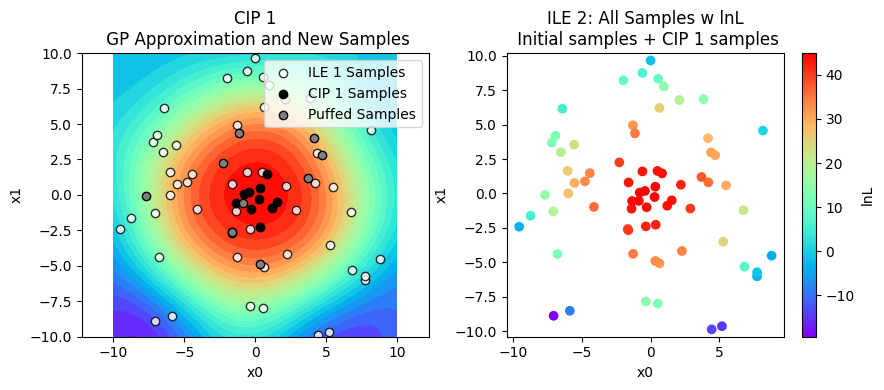

In [6]:
# Given "ILE" output from iter_0 on initial grid
# CIP generates test points based on the likelihood fit
x_1=CIP(x_in_init,y_in_init)

# Then puffball adds random errors
x_1_puff = puffball(x_1)
# and we evaluate the likelihood on all those points
x_1_net = np.concatenate((x_in_init,x_1,x_1_puff))
y_1_net = np.concatenate((y_in_init,lnL_true(x_1), lnL_true(x_1_puff)))

# Plot
gp = fit_gp(x_in_init, y_in_init)
z_gp = gp.predict(xgrid).reshape(100, 100)

fig, axs = plt.subplots(1, 2, figsize=(9, 4))

cf = axs[0].contourf(xv, yv, z_gp, levels=30, cmap='rainbow')
axs[0].scatter(x_in_init[:, 0], x_in_init[:, 1], c='white', edgecolor='black', label='ILE 1 Samples', alpha=0.8)
axs[0].scatter(x_1[:, 0], x_1[:, 1], c='black', label='CIP 1 Samples')
axs[0].scatter(x_1_puff[:, 0], x_1_puff[:, 1], c='gray', edgecolor='black', label='Puffed Samples')
axs[0].set_title("CIP 1\n GP Approximation and New Samples")
axs[0].set_xlabel("x0")
axs[0].set_ylabel("x1")
axs[0].legend(loc='upper right')
axs[0].axis("equal")

sc = axs[1].scatter(x_1_net[:, 0], x_1_net[:, 1], c=y_1_net, cmap='rainbow')
axs[1].set_title("ILE 2: All Samples w lnL\n Initial samples + CIP 1 samples")
axs[1].set_xlabel("x0")
axs[1].set_ylabel("x1")
axs[1].axis("equal")
fig.colorbar(sc, ax=axs[1], label="lnL")

plt.tight_layout()
plt.show()

After fitting a Gaussian Process to the log-likelihood samples, we use it to propose new points (`CIP`). These are biased toward regions with higher likelihood. We also generate "puffed" points by adding small random displacements to help the sampler explore nearby areas.

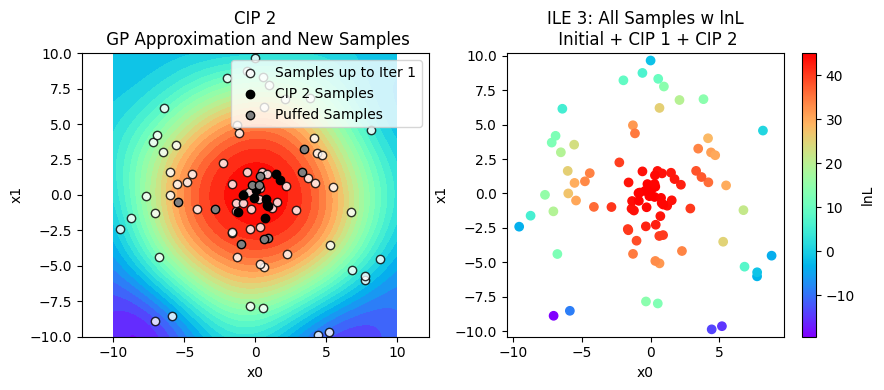

In [7]:
# Next - the first CIP output would be passed back to ILE to calculate
# the likelihoods at those points
# Then, CIP takes this new larger grid, with all the liklihood info and
# generates more test points based on the likelihood fit
x_2_0 = x_1_net; y_2_0 = y_1_net;
x_2_1 = CIP(x_2_0, y_2_0)

# Puffball adds more random errors
x_2_1_puff = puffball(x_2_1)

# Then in another round of "ILE", we evaluate the likelihood on those points
x_2_net = np.concatenate((x_2_0,x_2_1,x_2_1_puff))
y_2_net = np.concatenate((y_2_0,lnL_true(x_2_1), lnL_true(x_2_1_puff)))

fig, axs = plt.subplots(1, 2, figsize=(9, 4))

cf = axs[0].contourf(xv, yv, z_gp, levels=30, cmap='rainbow')
axs[0].scatter(x_1_net[:, 0], x_1_net[:, 1], c='white', edgecolor='black', label='Samples up to Iter 1', alpha=0.8)
axs[0].scatter(x_2_1[:, 0], x_2_1[:, 1], c='black', label='CIP 2 Samples')
axs[0].scatter(x_2_1_puff[:, 0], x_2_1_puff[:, 1], c='gray', edgecolor='black', label='Puffed Samples')
axs[0].set_title("CIP 2\n GP Approximation and New Samples")
axs[0].set_xlabel("x0")
axs[0].set_ylabel("x1")
axs[0].legend(loc='upper right')
axs[0].axis("equal")

sc = axs[1].scatter(x_2_net[:, 0], x_2_net[:, 1], c=y_2_net, cmap='rainbow')
axs[1].set_title("ILE 3: All Samples w lnL\n Initial + CIP 1 + CIP 2")
axs[1].set_xlabel("x0")
axs[1].set_ylabel("x1")
axs[1].axis("equal")
fig.colorbar(sc, ax=axs[1], label="lnL")

plt.tight_layout()
plt.show()

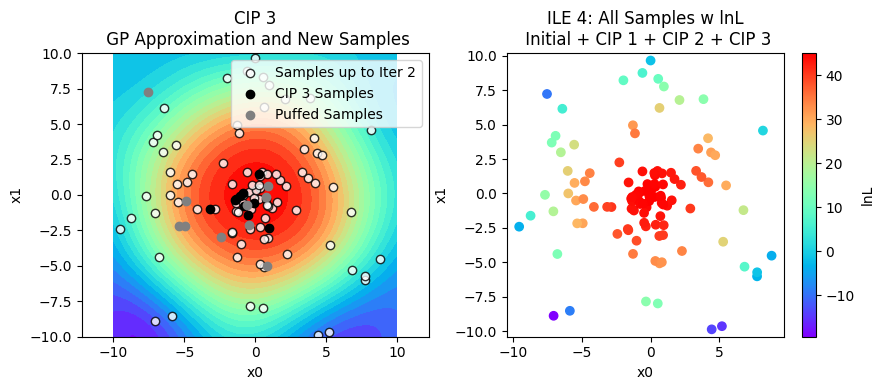

In [8]:
# You can see how, iteratively, CIP generates test points based on the likelihood fit
# it gets from ILE - which zeros in on regions of high likelihood
x_3_0 = x_2_net; y_3_0 = y_2_net;
x_3_1 = CIP(x_3_0, y_3_0)

# Puffball adds random errors after each stage to ensure coverage
x_3_1_puff = puffball(x_3_1)

# We always evaluate the likelihood on those points in an "ILE" round
# after a CIP round completes
x_3_net = np.concatenate((x_3_0,x_3_1,x_3_1_puff))
y_3_net = np.concatenate((y_3_0,lnL_true(x_3_1), lnL_true(x_3_1_puff)))

fig, axs = plt.subplots(1, 2, figsize=(9, 4))

cf = axs[0].contourf(xv, yv, z_gp, levels=30, cmap='rainbow')
axs[0].scatter(x_2_net[:, 0], x_2_net[:, 1], c='white', edgecolor='black', label='Samples up to Iter 2', alpha=0.8)
axs[0].scatter(x_3_1[:, 0], x_3_1[:, 1], c='black', label='CIP 3 Samples')
axs[0].scatter(x_3_1_puff[:, 0], x_3_1_puff[:, 1], c='gray', label='Puffed Samples')
axs[0].set_title("CIP 3\n GP Approximation and New Samples")
axs[0].set_xlabel("x0")
axs[0].set_ylabel("x1")
axs[0].legend(loc='upper right')
axs[0].axis("equal")

sc = axs[1].scatter(x_3_net[:, 0], x_3_net[:, 1], c=y_3_net, cmap='rainbow')
axs[1].set_title("ILE 4: All Samples w lnL\n Initial + CIP 1 + CIP 2 + CIP 3")
axs[1].set_xlabel("x0")
axs[1].set_ylabel("x1")
axs[1].axis("equal")
fig.colorbar(sc, ax=axs[1], label="lnL")

plt.tight_layout()
plt.show()

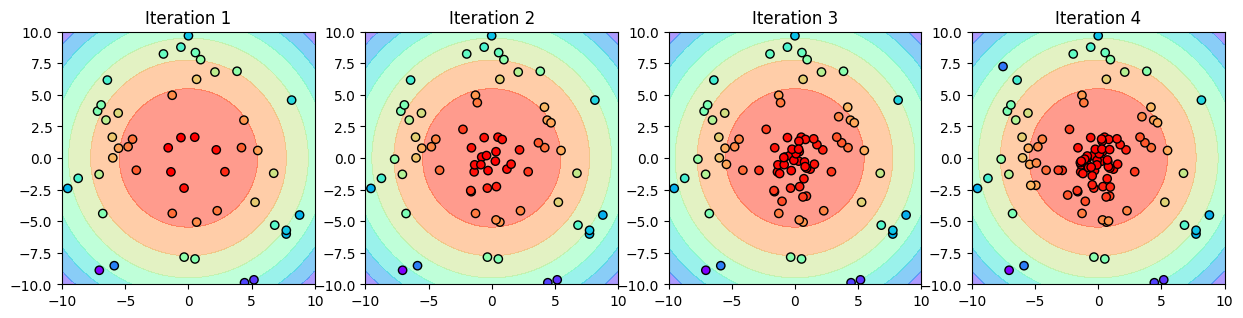

In [9]:
steps = [(x_in_init, y_in_init), (x_1_net, y_1_net), (x_2_net, y_2_net), (x_3_net, y_3_net)]
titles = ["Iteration 1", "Iteration 2", "Iteration 3", "Iteration 4"]

plt.figure(figsize=(15, 5)) 
for i, (x, y) in enumerate(steps):
    plt.subplot(1, 4, i+1, aspect='equal')
    plt.contourf(xv, yv, zgrid, levels=8, cmap='rainbow', alpha=0.5)
    plt.scatter(x[:,0], x[:,1], c=y, cmap='rainbow', edgecolor='k')
    plt.title(titles[i])

This sequence shows how the sampler progressively focuses on the high-likelihood region as more points are added and the GP model improves.

In [10]:
# At some point we decide we are done (usually via a convergence test), 
# we request a large sample of events from CIP as our final output
x_final = CIP(x_3_net,y_3_net,npts_out=5000)

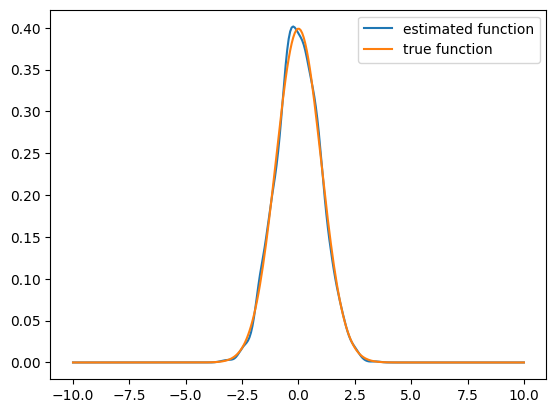

In [11]:
# Now we can make histograms of the result
#   - following scipy kde docs
# to see this "posterior" distribution
kernel= scipy.stats.gaussian_kde(x_final[:,0])
xvals = np.linspace(-10,10,300)
yvals=kernel(xvals)

# and we compare with the known answer we started with
yvals_true = 1/np.sqrt(2*np.pi) *np.exp(-45+lnL_true(np.array(list([x,0] for x in xvals)))
                   )
plt.plot(xvals,yvals, label='estimated function')
plt.plot(xvals,yvals_true,label='true function')
plt.legend();

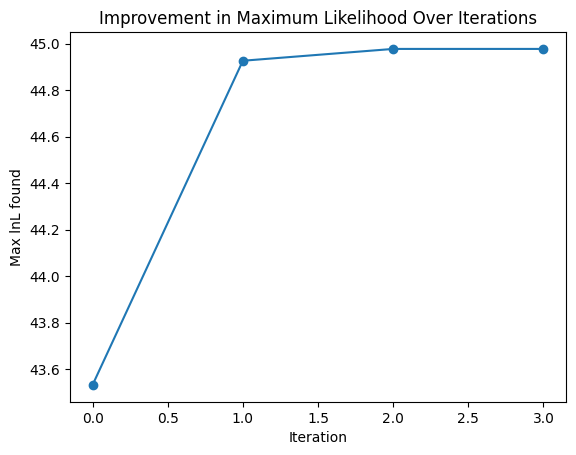

In [12]:
# The max likelihood increases in each iteration, reaching some final "maximum".
lnL_max_history = [np.max(y_in_init), np.max(y_1_net), np.max(y_2_net), np.max(y_3_net)]
plt.plot(lnL_max_history, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Max lnL found")
plt.title("Improvement in Maximum Likelihood Over Iterations");